下面展示了opencv-python的基本操作，包括：

（1）图像的读取与显示

（2）图像的色彩空间变换与通道分割

（3）图像裁剪、旋转、仿射变换与投影变换等

（4）图像亮度直方图均衡化

（5）图像的腐蚀和膨胀

In [2]:
import cv2
import matplotlib.pyplot as plt
import numpy as np
import random

### Read Image:  cv2.imread

cv2.IMREAD_COLOR reads the image with RGB colors but no transparency channel. This is the default value for the flag when no value is provided as the second argument for cv2 imread().

cv2.IMREAD_GRAYSCALE reads the image as grey image. If the source image is color image, grey value of each pixel is calculated and is read into the array.

cv2.IMREAD_UNCHANGED reads the image as is from the source. If the source image is an RGB, it loads the image into array with Red, Green and Blue channels. If the source image is ARGB, it loads the image with three color components along with the alpha or transparency channel.


In [3]:
# 图片读取用cv2.imread
"""
cv2.imread(filepath, flags)
"""
img_ori = cv2.imread('lenna.jpg',cv2.IMREAD_COLOR) # cv2.IMREAD_COLOR表示RGB模式，但注意读进来是BGR顺序
img_ori.shape

(500, 500, 3)

### Display Image: cv2.imshow

This function displays the image in a window and takes input for the title of the window and the image variable.
The window displays the image but it closes immediately, so to make the window display the image until we press a key on the keyboard we use the cv2.waitKey(0) function.

Hence when the window opens click any key on the keyboard and the window will close. cv2.destroyAllWindows() will properly close all the resources used for creating and showing the window.

即imshow后需要cv2.waitKey()，否则程序执行完显示就结束了。

In [4]:
#cv2.imshow显示图片
cv2.imshow('lenna_photo',img_ori)
key = cv2.waitKey(0) #0代表无限等待
if key == 27: #27是ESC的ASCII码，即按下ESC关会闭弹出的图片窗
    cv2.destroyAllWindows()

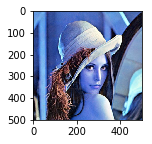

In [5]:
#plt也可以打印图片，但注意plt处理RGB图像通道顺序为RGB，和opencv默认的正好相反
plt.figure(figsize=(2,2))
plt.imshow(img_ori)
plt.show()

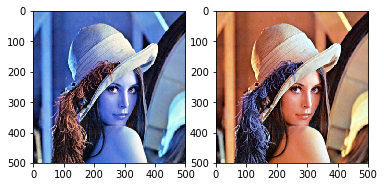

In [6]:
#subplot子图
plt.subplot(121)#1行2列，这是第1个
plt.imshow(img_ori)

plt.subplot(122)#1行2列，这是第2个
#用plt正确打印opencv的图像，需要通过cv2.cvtColor进行通道顺序变换
plt.imshow(cv2.cvtColor(img_ori,cv2.COLOR_BGR2RGB))
plt.show()

In [7]:
# 将通道变换与显示定义为函数，以供后续使用
def my_show(img, size=(3,3)):
    plt.figure(figsize=size)
    plt.imshow(cv2.cvtColor(img,cv2.COLOR_BGR2RGB))
    plt.show()

## image crop 图像裁剪

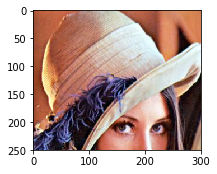

In [8]:
# 图片的原点为左上角
my_show(img_ori[50:300, 100:400])

## channel split 通道分割

In [9]:
B,G,R = cv2.split(img_ori)
# 分别显示R, G, B通道的亮度
cv2.imshow('B', B)
cv2.imshow('G', G)
cv2.imshow('R' ,R)
key = cv2.waitKey(0)
if key == 27:
    cv2.destroyAllWindows()

## 图像变冷

In [11]:
# 冷暖其实是人的主观看法，红色是暖色，蓝色是冷色，绿色是中性色
# 因此图像变冷是，提高B通道的亮度，降低R通道的亮度
def img_cooler(img,b_increase,r_decrease):
    B,G,R = cv2.split(img) #首先分割通道
    
    #然后提高B通道的亮度
    b_lim = 255 - b_increase
    B[B>b_lim] = 255
    B[B<=b_lim] = (b_increase + B[B<=b_lim]).astype(img.dtype)
    
    #降低R通道的亮度
    r_lim = r_decrease
    R[R<r_lim] = 0
    R[R>=r_lim] = (R[R>=r_lim] - r_decrease).astype(img.dtype)
    return cv2.merge((B,G,R)) #最后合并通道

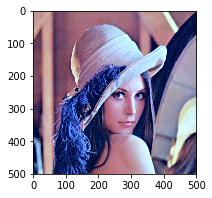

In [12]:
cooler_image = img_cooler(img_ori,50,30)
my_show(cooler_image)
# 可以看出，图片色调整体变蓝，让人感觉更“冷”

## Gamma Change

In [13]:
# Look Up Table的效率高
def adjust_gamma(img, gamma=1.0):
    invGamma = 1.0/gamma
    table = []
    for i in range(256):
        table.append(((i/255.0)**invGamma)*255)
    table = np.array(table).astype('uint8')
    return cv2.LUT(img,table)

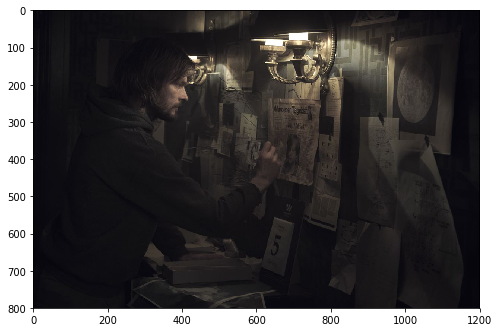

In [14]:
img_dark = cv2.imread('dark.jpg',1)
my_show(img_dark,size=(8,8))

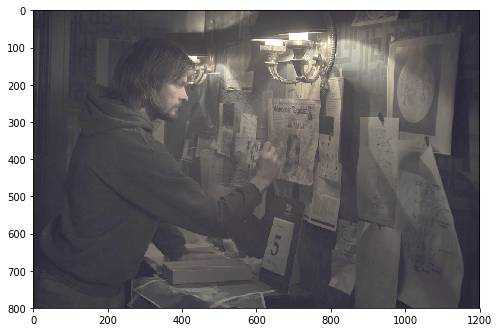

In [15]:
img_brighter = adjust_gamma(img_dark,2)
my_show(img_brighter,size=(8,8))

## 直方图均衡

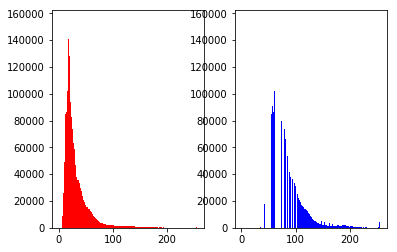

In [16]:
plt.subplot(121)
plt.hist(img_dark.flatten(),256,[0,256],color='r') #显示亮度的直方图
plt.subplot(122)
plt.hist(img_brighter.flatten(),256,[0,256],color='b')
plt.show()
#可见亮度分布在一个狭小范围

In [17]:
img_yuv = cv2.cvtColor(img_dark,cv2.COLOR_BGR2YUV) # BGR转YUV
img_yuv[:,:,0] = cv2.equalizeHist(img_yuv[:,:,0]) # 对Y通道单独进行调整，因为Y代表亮度
img_output = cv2.cvtColor(img_yuv,cv2.COLOR_YUV2BGR) # YUV转BGR

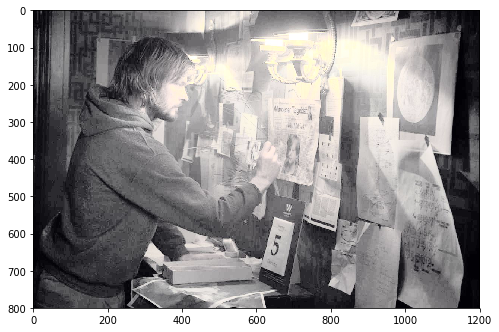

In [18]:
my_show(img_output,size=(8,8))

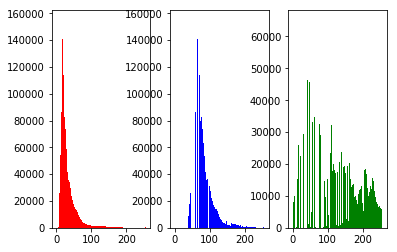

In [19]:
plt.subplot(131)
plt.hist(img_dark.flatten(),256,[0,256],color='r')
plt.subplot(132)
plt.hist(img_brighter.flatten(),256,[0,256],color='b')
plt.subplot(133)
plt.hist(img_output.flatten(),256,[0,256],color='g')
plt.show()
#经过直方图均衡后，亮度分布比较均匀

# transform
相似变换 similarity transform = rotation + translation + scale，具有保角性

仿射变换 affine transform，具有保持平行性

投影变换 perspective transform，具有保线性

In [20]:
#投影变换有8个自由度，确定变换矩阵需要4对点
pts1 = np.float32([[0,0],[0,500],[500,0],[500,500]])  # 源点创建
pts2 = np.float32([[5,19],[19,460],[460,9],[410,420]])  # 目标点创建

M = cv2.getPerspectiveTransform(pts1,pts2)  # 计算得到单应性矩阵
img_warp = cv2.warpPerspective(img_ori,M,(500,500))  # 通过得到的矩阵对图片进行变换

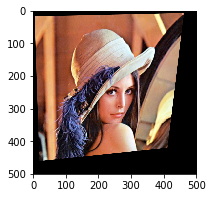

In [21]:
my_show(img_warp)

In [22]:
# rotation
img = img_ori
#获取旋转参数，三个输入依次为旋转中心，角度和缩放比例
M = cv2.getRotationMatrix2D((img.shape[1] / 2, img.shape[0] / 2), 30, 1) # center, angle, scale
img_rotate = cv2.warpAffine(img, M, (img.shape[1], img.shape[0]))
cv2.imshow('rotated lenna', img_rotate)
key = cv2.waitKey(0)
if key == 27:
    cv2.destroyAllWindows()

print(M)

# set M[0][2] = M[1][2] = 0
print(M)
img_rotate2 = cv2.warpAffine(img, M, (img.shape[1], img.shape[0]))
cv2.imshow('rotated lenna2', img_rotate2)
key = cv2.waitKey(0)
if key == 27:
    cv2.destroyAllWindows()
# explain translation

# scale+rotation+translation = similarity transform
M = cv2.getRotationMatrix2D((img.shape[1] / 2, img.shape[0] / 2), 30, 0.5) # center, angle, scale
img_rotate = cv2.warpAffine(img, M, (img.shape[1], img.shape[0]))
cv2.imshow('rotated lenna', img_rotate)
key = cv2.waitKey(0)
if key == 27:
    cv2.destroyAllWindows()

print(M)

##############################
# Affine Transform
# 仿射变换有6个自由度，确定变换矩阵需要3对点
rows, cols, ch = img.shape
pts1 = np.float32([[0, 0], [cols - 1, 0], [0, rows - 1]])
pts2 = np.float32([[cols * 0.2, rows * 0.1], [cols * 0.9, rows * 0.2], [cols * 0.1, rows * 0.9]])
 
M = cv2.getAffineTransform(pts1, pts2)
dst = cv2.warpAffine(img, M, (cols, rows))

cv2.imshow('affine lenna', dst)
key = cv2.waitKey(0)
if key == 27:
    cv2.destroyAllWindows()

############################
# perspective transform
def random_warp(img, row, col):
    height, width, channels = img.shape

    # warp:
    random_margin = 60
    x1 = random.randint(-random_margin, random_margin)
    y1 = random.randint(-random_margin, random_margin)
    x2 = random.randint(width - random_margin - 1, width - 1)
    y2 = random.randint(-random_margin, random_margin)
    x3 = random.randint(width - random_margin - 1, width - 1)
    y3 = random.randint(height - random_margin - 1, height - 1)
    x4 = random.randint(-random_margin, random_margin)
    y4 = random.randint(height - random_margin - 1, height - 1)

    dx1 = random.randint(-random_margin, random_margin)
    dy1 = random.randint(-random_margin, random_margin)
    dx2 = random.randint(width - random_margin - 1, width - 1)
    dy2 = random.randint(-random_margin, random_margin)
    dx3 = random.randint(width - random_margin - 1, width - 1)
    dy3 = random.randint(height - random_margin - 1, height - 1)
    dx4 = random.randint(-random_margin, random_margin)
    dy4 = random.randint(height - random_margin - 1, height - 1)

    pts1 = np.float32([[x1, y1], [x2, y2], [x3, y3], [x4, y4]])
    pts2 = np.float32([[dx1, dy1], [dx2, dy2], [dx3, dy3], [dx4, dy4]])
    M_warp = cv2.getPerspectiveTransform(pts1, pts2)
    img_warp = cv2.warpPerspective(img, M_warp, (width, height))
    return M_warp, img_warp

M_warp, img_warp = random_warp(img, img.shape[0], img.shape[1])
cv2.imshow('lenna_warp', img_warp)
key = cv2.waitKey(0)
if key == 27:
    cv2.destroyAllWindows()

[[  0.8660254    0.5        -91.50635095]
 [ -0.5          0.8660254  158.49364905]]
[[  0.8660254    0.5        -91.50635095]
 [ -0.5          0.8660254  158.49364905]]
[[  0.4330127    0.25        79.24682453]
 [ -0.25         0.4330127  204.24682453]]


## 膨胀和腐蚀

In [23]:
img_writing = cv2.imread('libai.png',cv2.IMREAD_GRAYSCALE)

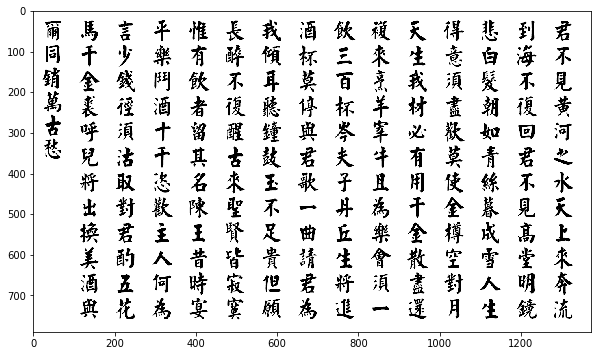

In [24]:
plt.figure(figsize=(10,8))
plt.imshow(img_writing,cmap='gray')
plt.show()

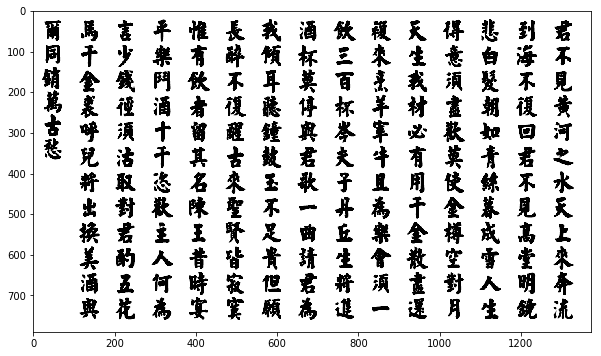

In [25]:
#腐蚀是找（亮度的）局部最小值，因此亮度低（偏黑）的部分会变多
#None表示核的大小默认，为3*3
erode_writing = cv2.erode(img_writing,None,iterations=1) 
plt.figure(figsize=(10,8))
plt.imshow(erode_writing,cmap='gray')
plt.show()

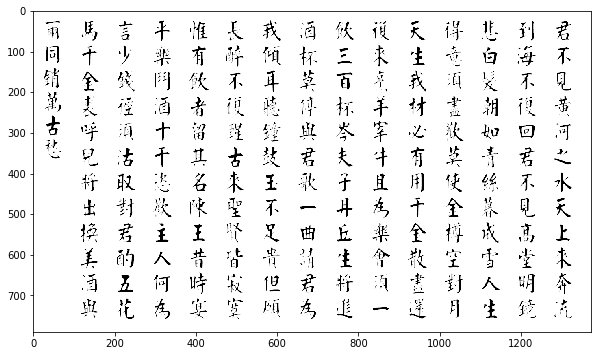

In [26]:
#腐蚀是找（亮度的）局部最大值，因此亮度大（偏白）的部分会变多
#None表示核的大小默认，为3*3
dilate_writing = cv2.dilate(img_writing,None,iterations=1)
plt.figure(figsize=(10,8))
plt.imshow(dilate_writing,cmap='gray')
plt.show()